In [13]:
%load_ext autoreload
%autoreload 2
import datetime
import torch
import random
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from ml_dl_fl.vaegan import VAE, VAEGAN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
device = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
writer = SummaryWriter("runs/vae" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

Device: cuda:0


In [15]:
## Function for data import

def import_data(path):
    input_data = np.load(path)
    input_data = np.swapaxes(input_data, 1, 2)
    input_data = input_data[:512000,:,:]
    print("Data:", np.shape(input_data))

    train_size, val_size, test_size = int(0.6*input_data.shape[0]), int(0.2*input_data.shape[0]), int(0.2*input_data.shape[0])

    train_dataset, val_dataset, test_dataset = [input_data[i] for i in range(train_size)], [input_data[i] for i in range(train_size, train_size+val_size)], [input_data[i] for i in range(train_size+val_size, train_size+val_size+test_size)]

    print("Train:", train_size)
    print("Val:", val_size)
    print("Test:", test_size)
    print("Total:", train_size+val_size+test_size)
    print()

    return train_dataset, val_dataset, test_dataset

In [16]:
# Load data
print("Loading Alice data:")
alice_train, alice_val, alice_test = import_data('../data/phase_dataset_alice.npy')
print("Loading Bob data:")
bob_train, bob_val, bob_test = import_data('../data/phase_dataset_bob.npy')

Loading Alice data:
Data: (512000, 1, 56)
Train: 307200
Val: 102400
Test: 102400
Total: 512000

Loading Bob data:
Data: (512000, 1, 56)
Train: 307200
Val: 102400
Test: 102400
Total: 512000



In [17]:
# Hyperparameters
learning_rate = 0.001
shared_dim = 1
exclusive_dim = 128
epochs = 5
batch_size = 256
l1_rec_coeff = 1
l1_sh_coeff = 1
kl_coeff = 1

# model alice
model = VAE(alice_train, alice_val, alice_test, bob_train, bob_val, bob_test, shared_dim=shared_dim, exclusive_dim=exclusive_dim, lr=learning_rate, writer=writer, batch_size=batch_size, epochs=epochs, l1_rec_coeff=l1_rec_coeff, l1_sh_coeff=l1_sh_coeff, kl_coeff=kl_coeff).to(device)
print("Using", device)
#summary(model, [(1, 56), (1, 56)], device=device)
model.train_model()

Using cuda:0


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH 1


 20%|██        | 1/5 [00:38<02:32, 38.14s/it]

EPOCH 2


 40%|████      | 2/5 [01:12<01:47, 35.97s/it]

EPOCH 3


 60%|██████    | 3/5 [01:55<01:18, 39.01s/it]

EPOCH 4


 80%|████████  | 4/5 [02:36<00:40, 40.02s/it]

EPOCH 5


100%|██████████| 5/5 [03:14<00:00, 38.95s/it]


In [18]:
def disentangle_csi(alice_data, bob_data, number_of_samples):
    alice_shared = []
    bob_shared = []
    alice_exclusive = []
    bob_exclusive = []
    ## Get shared and exclusive data

    for index in tqdm(range(number_of_samples)):
        #s = random.randint(0, len(alice_test))

        img_x = alice_data[index]
        img_y = bob_data[index]

        ## Normalize measurements

        norm_x = (img_x[0] - np.mean(img_x[0])) / np.std(img_x[0])
        norm_y = (img_y[0] - np.mean(img_y[0])) / np.std(img_y[0])

        ## Extract shared data for x and y

        sh_x = model.encoder_sh(torch.Tensor(img_x[None, :]).to(device))[0].cpu().detach().numpy()[0]
        sh_y = model.encoder_sh(torch.Tensor(img_y[None, :]).to(device))[0].cpu().detach().numpy()[0]

        ## Extract exclusive data for x and y
        
        ex_x = model.encoder_ex(torch.Tensor(img_x[None, :]).to(device))[0].cpu().detach().numpy()[0]
        ex_y = model.encoder_ex(torch.Tensor(img_y[None, :]).to(device))[0].cpu().detach().numpy()[0]

        ## Save values

        alice_shared.append(sh_x)
        bob_shared.append(sh_y)
        alice_exclusive.append(ex_x)
        bob_exclusive.append(ex_y)

    alice_shared = np.array(alice_shared)
    bob_shared = np.array(bob_shared)
    alice_exclusive = np.array(alice_exclusive)
    bob_exclusive = np.array(bob_exclusive)

    return alice_shared, alice_exclusive, bob_shared, bob_exclusive

In [19]:
alice_shared, alice_exclusive, bob_shared, bob_exclusive = disentangle_csi(alice_test, bob_test, 10000)

100%|██████████| 10000/10000 [01:10<00:00, 141.35it/s]


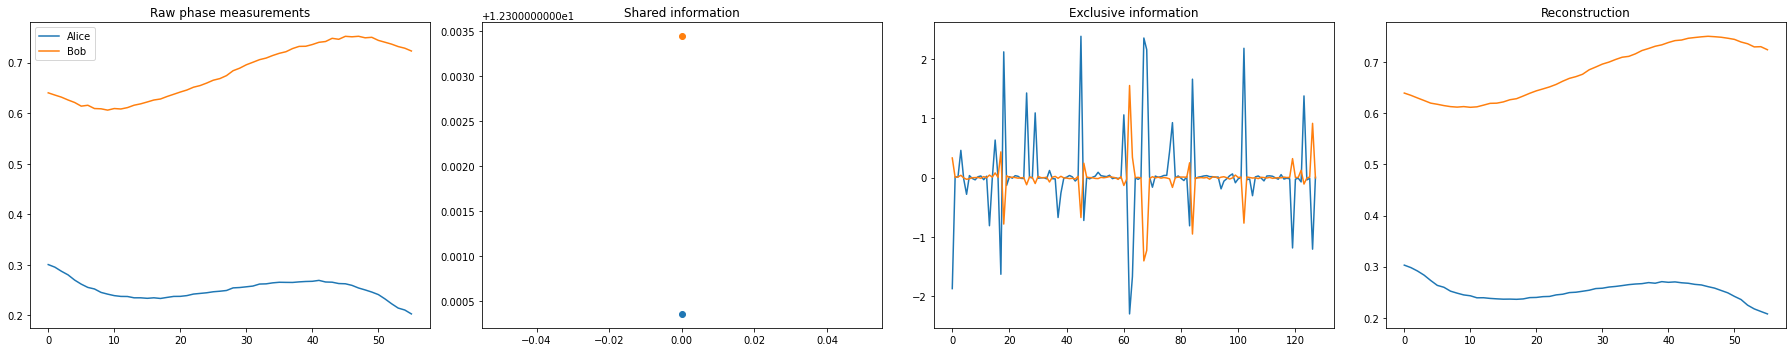

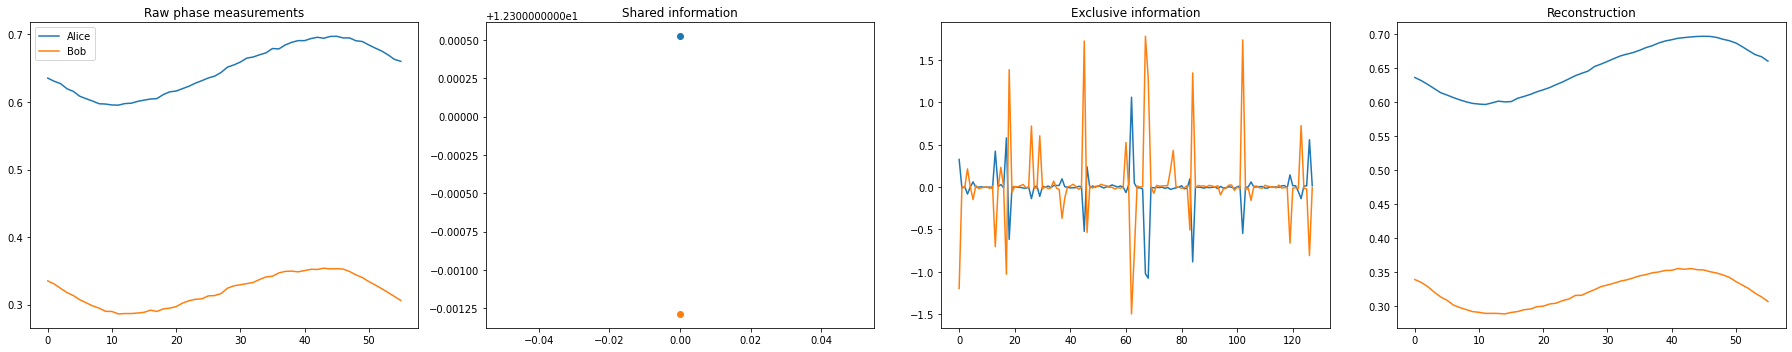

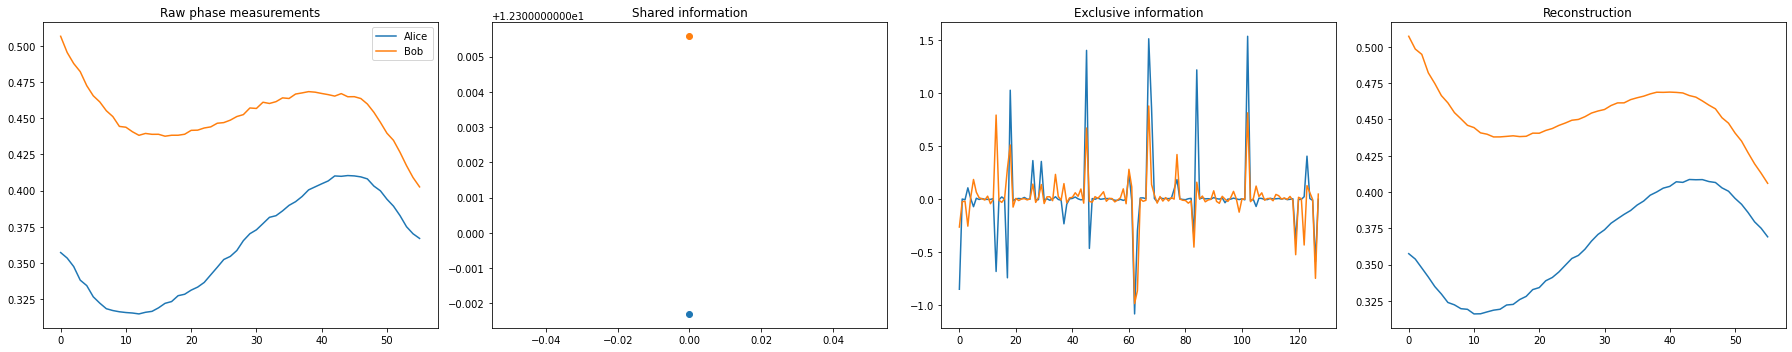

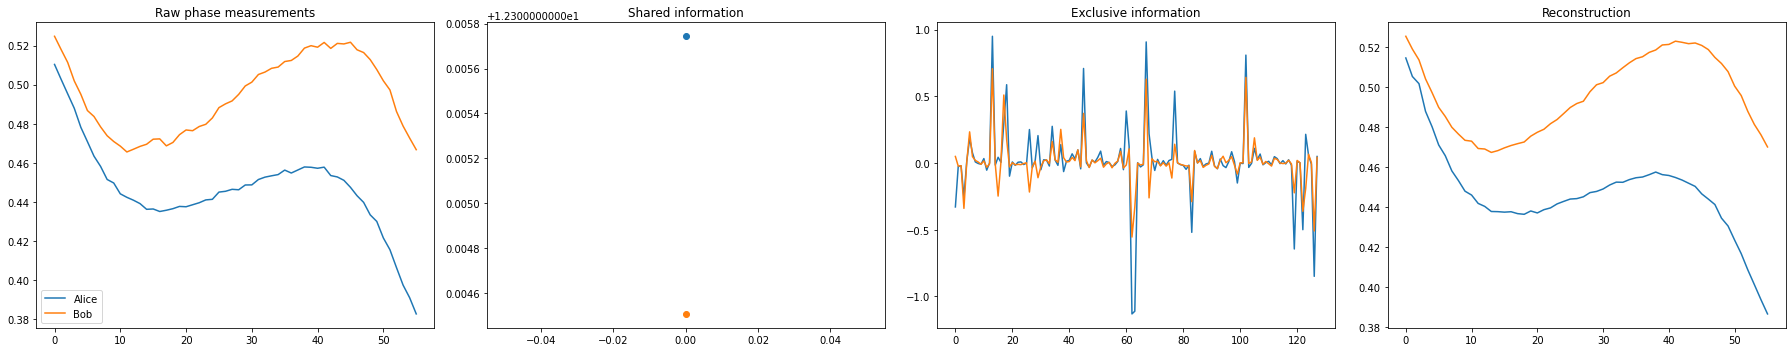

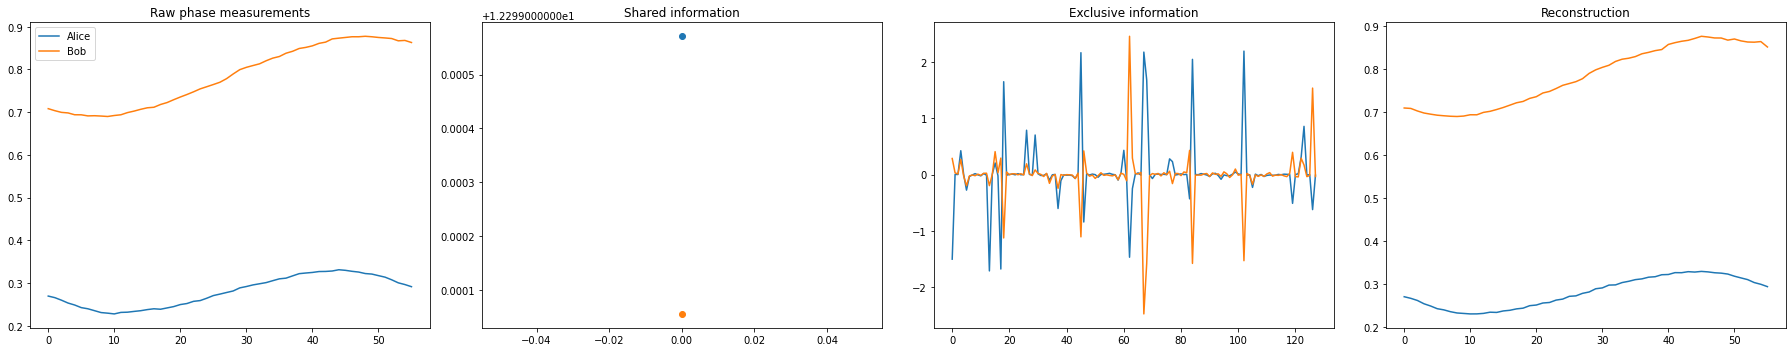

In [20]:
## Plot measurement, shared and exclusive in one plot
for i in range(5):
    s = random.randint(0, len(alice_shared))
    fig, axs = plt.subplots(1, 4, figsize=(25, 5))

    img_x = alice_test[s]
    img_y = bob_test[s]

    axs[0].plot(img_x[0, :], label="Alice")
    axs[0].plot(img_y[0, :], label="Bob")
    axs[0].set_title("Raw phase measurements")
    axs[0].legend()

    axs[1].scatter(0, alice_shared[s])
    axs[1].scatter(0, bob_shared[s])
    axs[1].set_title("Shared information")

    axs[2].plot(alice_exclusive[s])
    axs[2].plot(bob_exclusive[s])
    axs[2].set_title("Exclusive information")

    rec_input_sh_x = torch.unsqueeze(torch.Tensor(alice_shared[s]), dim=0).to(device)
    rec_input_ex_x = torch.unsqueeze(torch.Tensor(alice_exclusive[s]), dim=0).to(device)
    rec_x = model.decoder(rec_input_sh_x, rec_input_ex_x)[0].cpu().detach().numpy()[0]

    rec_input_sh_y = torch.unsqueeze(torch.Tensor(bob_shared[s]), dim=0).to(device)
    rec_input_ex_y = torch.unsqueeze(torch.Tensor(bob_exclusive[s]), dim=0).to(device)
    rec_y = model.decoder(rec_input_sh_y, rec_input_ex_y)[0].cpu().detach().numpy()[0]

    axs[3].plot(rec_x)
    axs[3].plot(rec_y)
    axs[3].set_title("Reconstruction")

    plt.tight_layout()
    #plt.savefig("figs/" + str(i) + ".png")
    plt.show()
    plt.close()

100%|██████████| 1000/1000 [00:03<00:00, 252.51it/s]


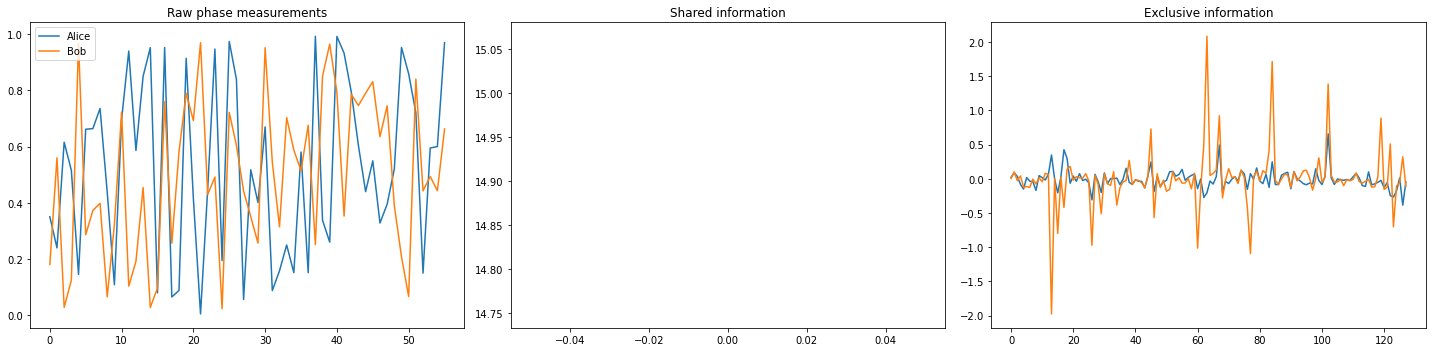

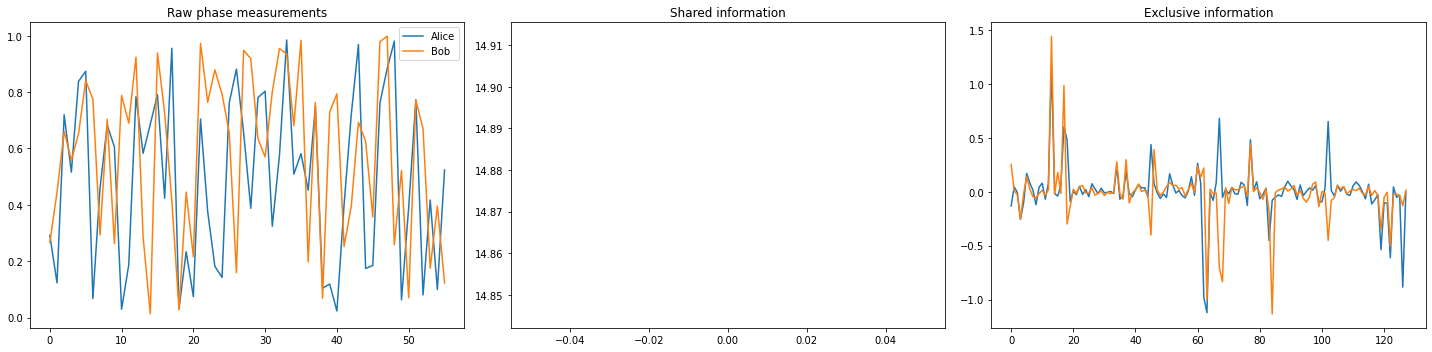

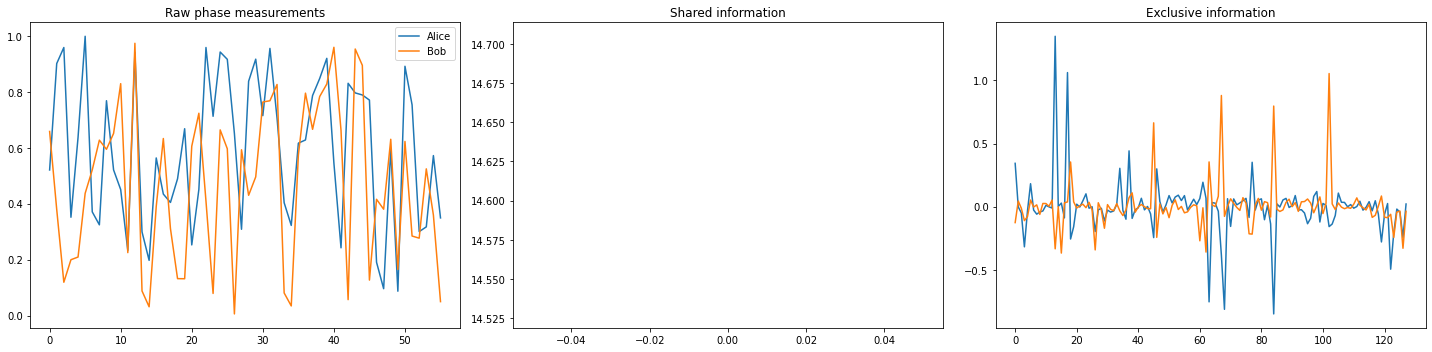

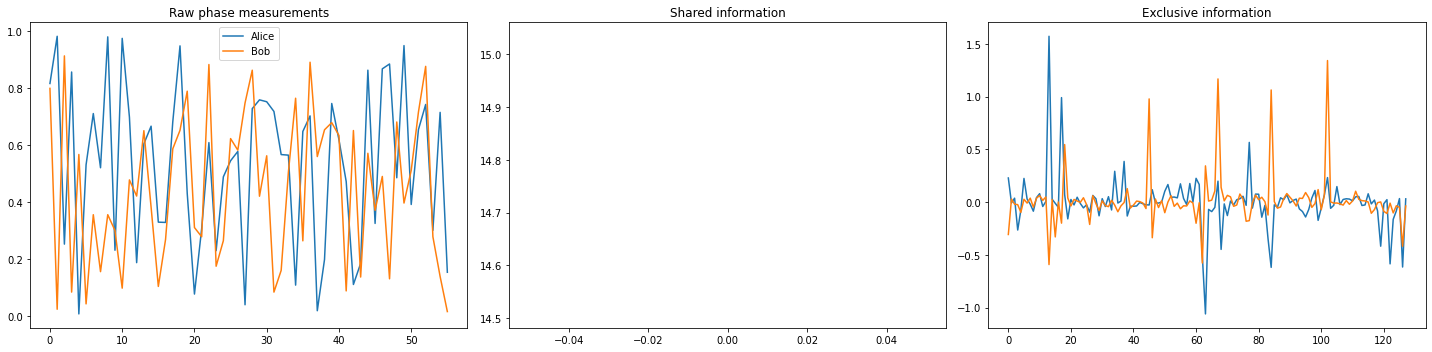

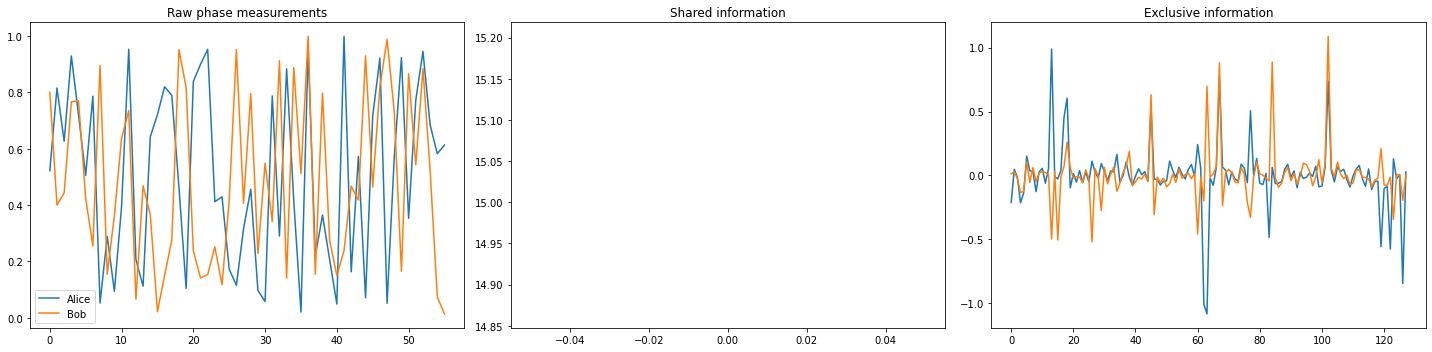

In [21]:
alice_random = []
bob_random = []
for _ in range(1000):
    alice_random.append(np.random.rand(1, 56))
    bob_random.append(np.random.rand(1, 56))

#for _ in range(1000):
#    alice_random.append(np.linspace(-2, 2, 56).reshape(1, -1))
#    #bob_random.append(np.random.rand(1, 56))
#bob_random = alice_random


alice_random_shared, alice_random_exclusive, bob_random_shared, bob_random_exclusive = disentangle_csi(alice_random, bob_random, 1000)

for s in range(5):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    axs[0].plot(alice_random[s][0], label="Alice")
    axs[0].plot(bob_random[s][0], label="Bob")
    axs[0].set_title("Raw phase measurements")
    axs[0].legend()

    axs[1].plot(alice_random_shared[s])
    axs[1].plot(bob_random_shared[s])
    axs[1].set_title("Shared information")

    axs[2].plot(alice_random_exclusive[s])
    axs[2].plot(bob_random_exclusive[s])
    axs[2].set_title("Exclusive information")

    plt.tight_layout()
    plt.show()
    plt.close()

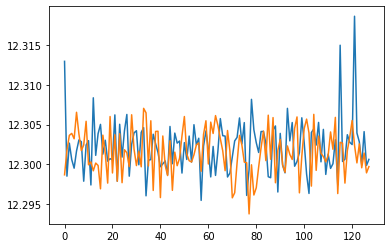

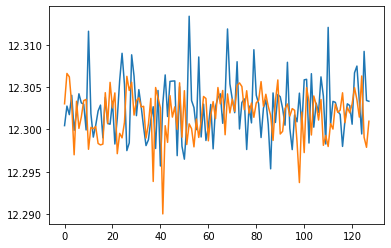

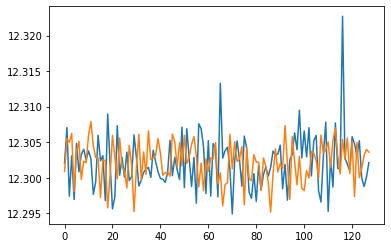

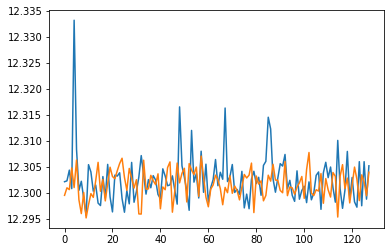

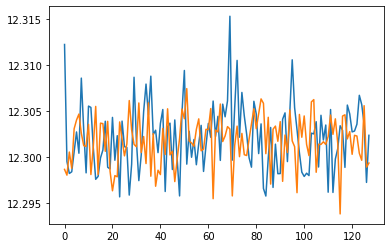

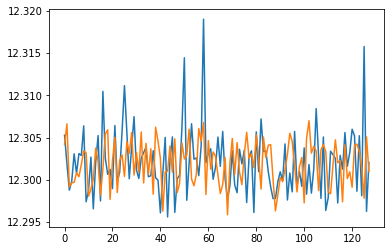

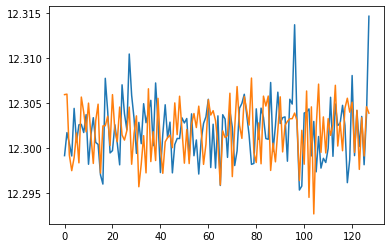

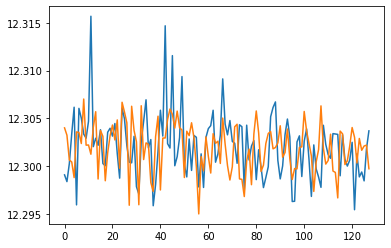

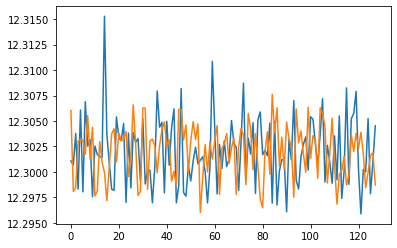

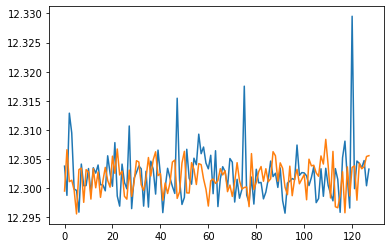

In [22]:
### KEY
for i in range(10):
    plt.plot(alice_shared[i*128:i*128+128])
    plt.plot(bob_shared[i*128:i*128+128])
    plt.show()
    plt.close()

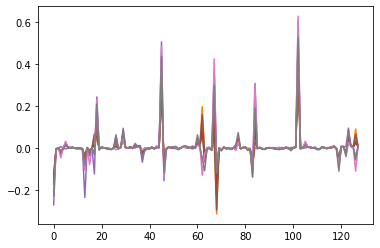

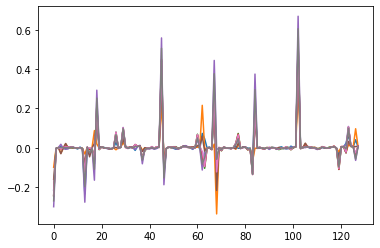

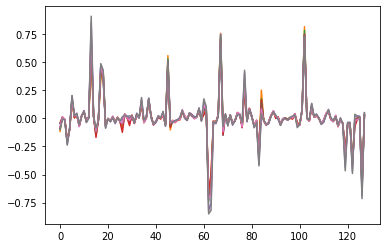

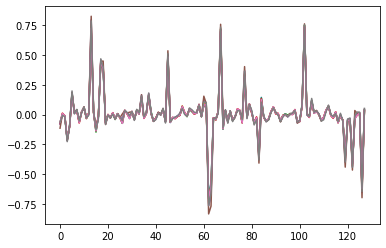

In [23]:
### FINGERPRINT
n_samples = 8

for i in range(n_samples):
    new = np.mean(alice_exclusive[i*128:i*128+128, :], axis=0)
    plt.plot(new)
plt.show()
#plt.savefig("figs/alice_avg.png")
plt.close()

for i in range(n_samples):
    new = np.mean(bob_exclusive[i*128:i*128+128, :], axis=0)
    plt.plot(new)
plt.show()
#plt.savefig("figs/bob_avg.png")
plt.close()

for i in range(n_samples):
    new = np.mean(alice_random_exclusive[i*128:i*128+128, :], axis=0)
    plt.plot(new)
plt.show()
#plt.savefig("figs/alice_avg.png")
plt.close()

for i in range(n_samples):
    new = np.mean(bob_random_exclusive[i*128:i*128+128, :], axis=0)
    plt.plot(new)
plt.show()
#plt.savefig("figs/bob_avg.png")
plt.close()

In [24]:
def plot_reconstruction(model, n=30):
    fig, axs = plt.subplots(2, n, figsize=(40, 5))

    for i in range(n):
        model.to(device)
        s = np.random.randint(0, 169472, 1)[0]
        data = torch.tensor(alice_test[s][0])[None, None, :].float()
        data = data.to(device)
        mu, log_var = model.encoder(data)
        z = model.reparametrize(mu, log_var)
        reconstruction = model.decoder(z)
        critic_real = model.discriminator(data)
        critic_fake = model.discriminator(reconstruction)
        #axs[0, i].set_ylim([0, 1])
        #axs[1, i].set_ylim([0, 1])
        axs[0, i].plot(np.squeeze(data.cpu()))
        axs[0, i].set_title(f"s: {critic_real[0].item()}")
        axs[1, i].plot(np.squeeze(reconstruction.cpu().detach().numpy()))
        axs[1, i].set_title(f"s: {critic_fake[0].item()}")

    plt.show()
plot_reconstruction(model_alice, n = 10)

NameError: name 'model_alice' is not defined

tensor([-1.0531, -1.3861,  1.1172])
tensor([ 1.3636,  1.4040, -0.7530])
tensor([-1.0215,  1.1843, -1.0065])
tensor([ 0.7227, -0.2866,  0.7471])
tensor([-1.1207,  0.5367,  0.1399])
tensor([-0.0789, -0.6134, -0.2884])
tensor([ 0.0183, -0.6509, -0.9093])
tensor([-0.5771,  0.3131, -0.4953])
tensor([ 0.1459,  0.8801, -0.7142])
tensor([ 0.5461,  0.3806, -1.4761])


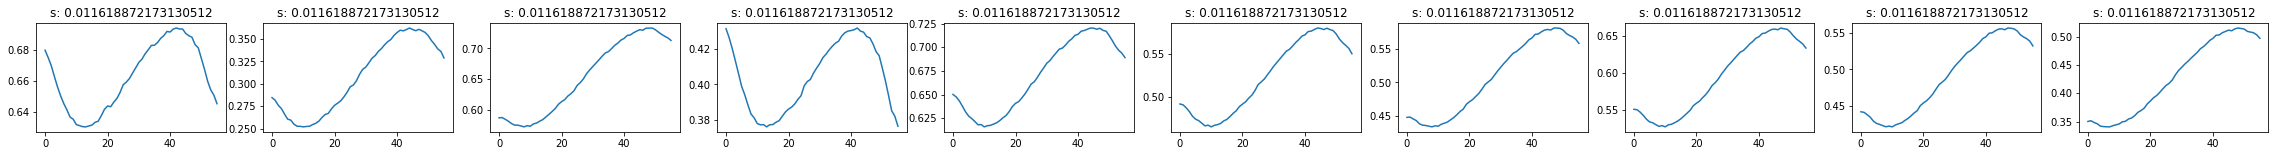

In [ ]:
def gen_new(model, n):
    fig, axs = plt.subplots(1, n, figsize=(40, 2))
    for i in range(n):
        z = torch.distributions.Normal(0, 1).sample(torch.Size([1, 3])).to(device)
        x = model.decoder(z.float())
        print(z.squeeze().cpu())
        critic = model.discriminator(x)
        axs[i].plot(x.squeeze().cpu().detach().numpy())
        axs[i].set_title(f"s: {critic[0].item()}")
    plt.show()

gen_new(model_alice, 10)